In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
(ds_train, ds_test), ds_info = tfds. load (
    "cifar10", #it is name that is in catelog of link above
    split=["train", "test"],
    shuffle_files=True, #tf datasets store something in records in multiple files, for easy stream, loading simultaneously while training
                        # so it is for shuffles dataponits in batch so not sequential
    as_supervised=True, #it return tuple (image,label) otherwise it returns dict
    with_info=True, #for getting info

)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWPVO3N/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteWPVO3N/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir=PosixGPath('/tmp/tmpv0hdfiuctfds'),
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning mult

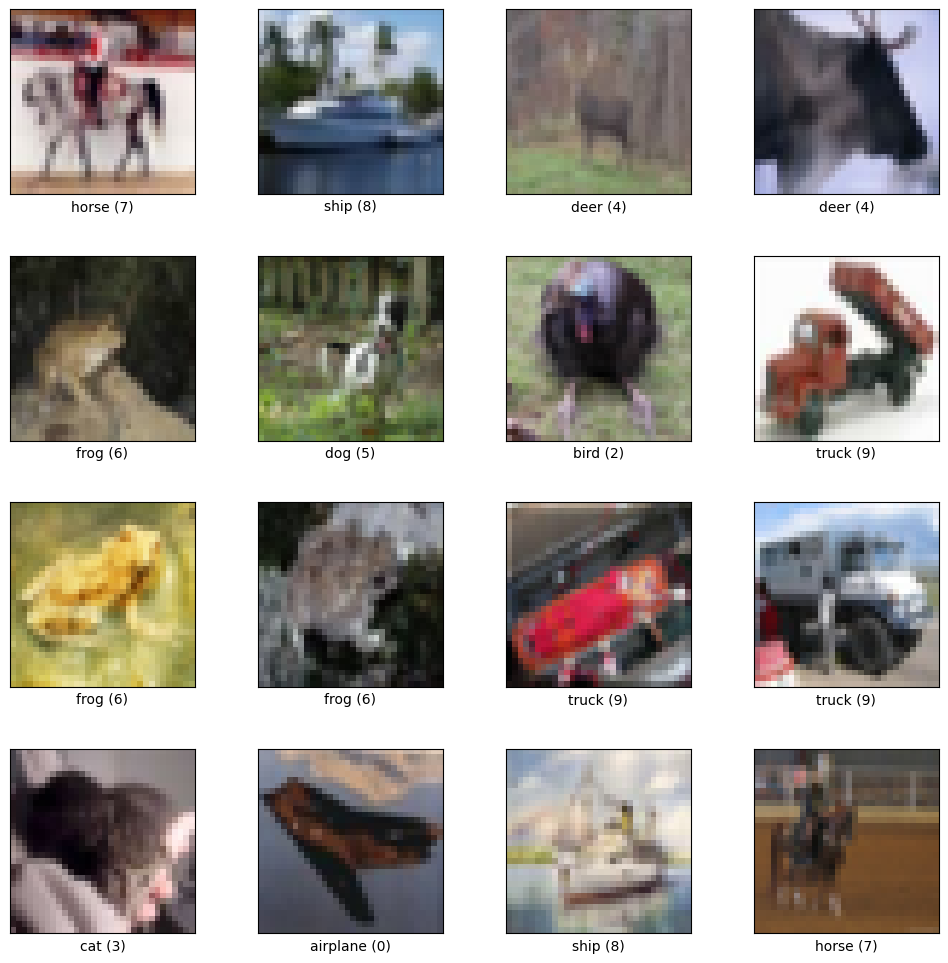

In [4]:
fig = tfds.show_examples (ds_train, ds_info, rows=4, cols=4)

In [5]:
def normalize_image(image, label):
  return tf.cast(image, tf.float32)/255.0, label

In [6]:
#two ways aug we do
#first assume working with tensflow dataset
#and other for custom dataset

In [7]:
def augment (image, label):
  new_height = new_width = 32

  image = tf.image.resize(image,(new_height, new_width)) #we are resizing here

  if tf.random.uniform((), minval=0, maxval=1) < 0.1: #we are converting to grayscale, randomly decide which to grey scale
    image = tf.image.rgb_to_grayscale (image)
    image=tf.tile(image, [1,1,3]) #our model need 32x32x3 input but grayscale give 1 channel so we copy that channel to make 3
    #and [1,1,3] define that copy last shape to 3 times

    #data augmentaton is done on tha fly, while gpu training on batch, cpu is augmenting the data
    #we cannot tell what is size that is created

  image = tf.image.random_brightness(image, max_delta=0.1)
  image = tf. image. random_contrast (image, lower=0.1, upper=0.2)

  image = tf.image.random_flip_left_right (image) # 50% data got flipped randomly
  # image = tf .image.random_flip_up_down (image) # 50%
  return image, label

In [8]:
AUTOTUNE=tf.data.experimental.AUTOTUNE #tf allow us to give this to set automatically
BATCH_SIZE=32

ds_train=ds_train.map(normalize_image, num_parallel_calls=AUTOTUNE) # in normalize function these is no sequence so
#process can be done paralelly
ds_train= ds_train.cache() #it keep next data in memory so it will be fast
ds_train=ds_train.shuffle(ds_info.splits['train'].num_examples) #we can give 1000 so it will see 1000 datat points but
#it depends on records in a file so take from that


ds_train=ds_train.map(augment, num_parallel_calls=AUTOTUNE)



ds_train=ds_train.batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE) #it keeps 64 examples ready when running on gpu the current one

In [9]:
ds_test=ds_test.map(normalize_image, num_parallel_calls=AUTOTUNE)
ds_test=ds_test.batch(128)
ds_test=ds_test.prefetch(AUTOTUNE)

In [10]:
#other way in newer tf is to crate model for augmentation, but it is not parallel just like previous one
#but it is more simple
data_augmentation = keras. Sequential (
[
    layers.experimental.preprocessing.Resizing (height=32, width=32),
    layers.experimental.preprocessing.RandomFlip (mode= "horizontal"),
    layers. experimental.preprocessing.RandomContrast (factor=0.1),
]
                                        )

In [11]:
model = keras. Sequential([
    keras. Input ((32, 32, 3)),

#   data_augmentation,

    layers.Conv2D(4, 3, padding="same", activation="relu"),
    layers.Conv2D(8, 3, padding="same", activation="relu"),
    layers. MaxPooling2D (),
    layers.Conv2D (16, 3, padding="same", activation="relu"),
    layers.Flatten(),
    layers. Dense (64, activation="relu"),
    layers. Dense (10),
])

In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 4)         112       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 8)         296       
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 8)         0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 64)                262208    
                                                      

In [13]:
model.compile(optimizer=keras.optimizers.Adam(),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"],
)
model.fit(ds_train, epochs=1, verbose=2)
model.evaluate(ds_test, verbose=2)

1563/1563 - 63s - loss: 2.0629 - accuracy: 0.2243 - 63s/epoch - 41ms/step
79/79 - 5s - loss: 2.8266 - accuracy: 0.2376 - 5s/epoch - 58ms/step


[2.826605796813965, 0.23759999871253967]